# Using PyMC3

PyMC3 is a Python package for doing MCMC using a variety of samplers, including Metropolis, Slice and Hamiltonian Monte Carlo. See [Probabilistic Programming in Python using PyMC](http://arxiv.org/abs/1507.08050) for a description. The GitHub [site](https://github.com/pymc-devs/pymc3) also has many examples and links for further exploration.

In [1]:
import pymc3 as pm
import numpy.random as rng
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler

## Coin bias

We start with the simplest model - that of determining the bias of a coin from observed outcomes.

### Setting up the model    

In [2]:
n = 100
heads = 61

#### Anaalytical solution

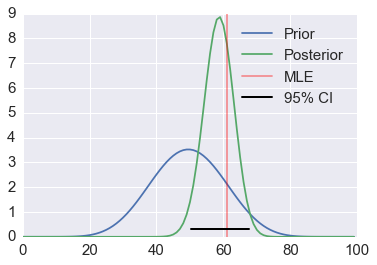

In [3]:
a, b = 10, 10
prior = stats.beta(a, b)
post = stats.beta(heads+a, n-heads+b)
ci = post.interval(0.95)

xs = np.linspace(0, 1, 100)
plt.plot(prior.pdf(xs), label='Prior')
plt.plot(post.pdf(xs), label='Posterior')
plt.axvline(100*heads/n, c='red', alpha=0.4, label='MLE')
plt.xlim([0, 100])
plt.axhline(0.3, ci[0], ci[1], c='black', linewidth=2, label='95% CI');
plt.legend()
pass

### Introduction to PyMC3

In [4]:
niter = 2000
with pm.Model() as coin_context:
    p = pm.Beta('p', alpha=2, beta=2)
    y = pm.Binomial('y', n=n, p=p, observed=heads)
    trace = pm.sample(niter)

Applied logodds-transform to p and added transformed p_logodds to model.
Assigned NUTS to p_logodds
 [-----------------100%-----------------] 2000 of 2000 complete in 0.8 sec

### Specifying start,  sampler (step) and multiple chains

In [5]:
with coin_context:
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(niter, step=step, start=start, njobs=4, random_seed=123)

 [-----------------100%-----------------] 2000 of 2000 complete in 0.4 sec

#### MAP estimate

In [6]:
start

{'p_logodds': array(0.42956266113384295)}

### Summary of results

#### Discard 50% as burn-in

In [7]:
t = trace[niter//2:]
t['p'].shape

(4000,)

#### Getting values from the trace

In [8]:
p = trace.get_values('p', burn=niter//2, combine=True, chains=[0,2])
p.shape

(2000,)

#### Autocorrelation plot

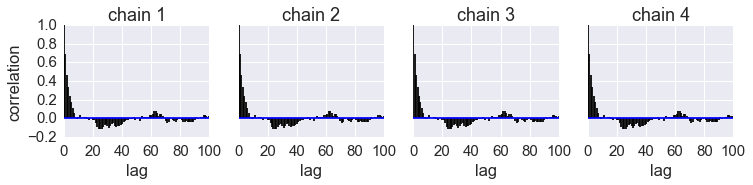

In [9]:
pm.autocorrplot(t, varnames=['p'])
pass

#### Calculate effective sample size

In [10]:
pm.effective_n(t)

{'p': 767, 'p_logodds': 765}

#### Evaluate convergence

In [11]:
pm.gelman_rubin(t)

{'p': 0.99949987493746095, 'p_logodds': 0.99949987493746095}

#### Textual summary

In [12]:
pm.summary(t, varnames=['p'])


p:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.615            0.050            0.002            [0.517, 0.698]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.517          0.581          0.616          0.654          0.698



#### Visual summary

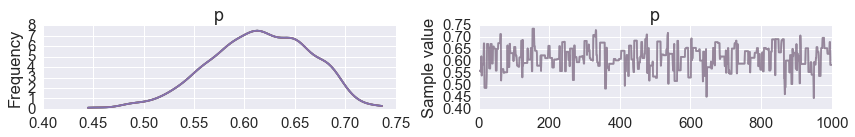

In [13]:
pm.traceplot(t, varnames=['p'])
pass

#### Posterior predictive samples

In [14]:
with coin_context:
    ppc = pm.sample_ppc(t, samples=100)
ppc['y'].ravel()

array([69, 59, 66, 59, 64, 51, 53, 58, 57, 65, 52, 58, 53, 71, 67, 70, 59,
       69, 61, 60, 65, 70, 58, 62, 73, 66, 70, 60, 54, 63, 63, 50, 64, 51,
       71, 62, 64, 77, 71, 69, 63, 66, 61, 51, 57, 62, 50, 68, 61, 68, 71,
       60, 61, 62, 72, 57, 68, 60, 72, 48, 53, 47, 64, 64, 73, 63, 54, 59,
       57, 73, 67, 56, 55, 59, 64, 53, 55, 66, 70, 64, 61, 58, 54, 67, 63,
       54, 55, 65, 73, 57, 55, 60, 68, 66, 68, 58, 51, 47, 51, 43])

### Saving traces

##### CSV

In [15]:
from pymc3.backends import Text

niter = 2000
with pm.Model() as text_save_demo:
    p = pm.Beta('p', alpha=2, beta=2)
    y = pm.Binomial('y', n=n, p=p, observed=heads)
    db = Text('trace')
    trace = pm.sample(niter, trace=db)

Applied logodds-transform to p and added transformed p_logodds to model.
Assigned NUTS to p_logodds
 [-----------------100%-----------------] 2000 of 2000 complete in 0.8 sec

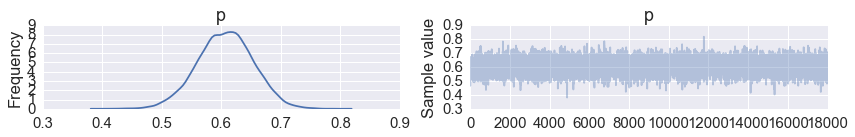

In [16]:
with text_save_demo:
    trace = pm.backends.text.load('trace')
    pm.traceplot(trace, varnames=['p'])

##### SQLite

If you are fitting a large complex model that may not fit in memory, you can use the SQLite3 backend to save the trace incremnetally to disk.

In [17]:
from pymc3.backends import SQLite

niter = 2000
with pm.Model() as sqlie3_save_demo:
    p = pm.Beta('p', alpha=2, beta=2)
    y = pm.Binomial('y', n=n, p=p, observed=heads)
    db = SQLite('trace.db')
    trace = pm.sample(niter, trace=db)

Applied logodds-transform to p and added transformed p_logodds to model.
Assigned NUTS to p_logodds
 [-----------------100%-----------------] 2000 of 2000 complete in 0.8 sec

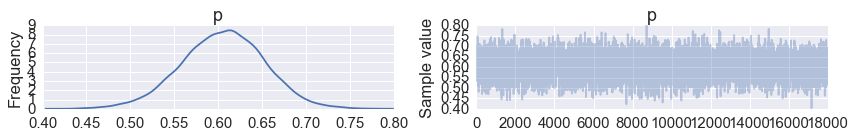

In [18]:
with sqlie3_save_demo:
    trace = pm.backends.sqlite.load('trace.db')
    pm.traceplot(trace, varnames=['p'])

## Univariate normal distribution

In [19]:
xs = rng.normal(loc=5, scale=2, size=100)

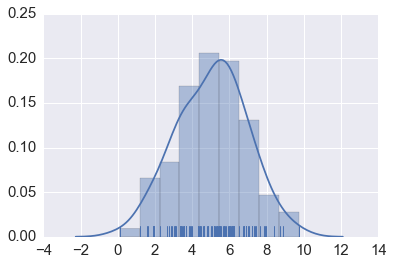

In [20]:
sns.distplot(xs, rug=True)
pass

In [21]:
niter = 2000
with pm.Model() as coin_context:
    mu = pm.Normal('mu', mu=0, sd=100)
    sd = pm.HalfCauchy('sd', beta=2)
    y = pm.Normal('y', mu=mu, sd=sd, observed=xs)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(niter, start=start, step=step)

Applied log-transform to sd and added transformed sd_log to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.2 sec

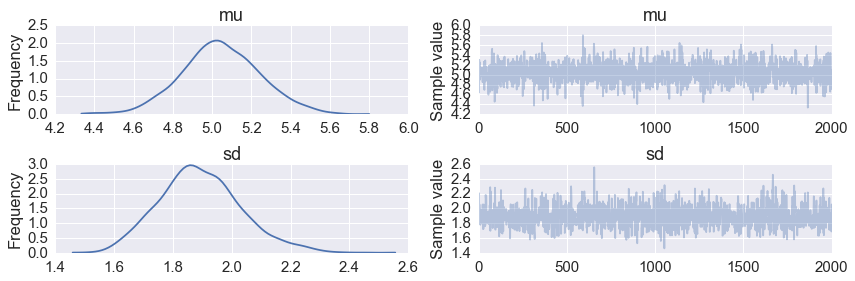

In [22]:
pm.traceplot(trace, varnames=['mu', 'sd'])
pass

## Linear regression


We will show how to estimate regression parameters using a simple linear model

$$
y \sim ax + b
$$

We can restate the linear model $$y = ax + b + \epsilon$$ as sampling from a probability distribution

$$
y \sim \mathcal{N}(ax + b, \sigma^2)
$$

Now we can use `pymc` to estimate the parameters $a$, $b$ and $\sigma$. We will assume the following priors

$$
a \sim \mathcal{N}(0, 100) \\
b \sim \mathcal{N}(0, 100) \\
\sigma \sim | \mathcal{N(0, 1)} |
$$

In [23]:
# observed data
np.random.seed(123)
n = 11
_a = 6
_b = 2
x = np.linspace(0, 1, n)
y = _a*x + _b + np.random.randn(n)

In [24]:
niter = 10000
with pm.Model() as linreg:
    a = pm.Normal('a', mu=0, sd=100)
    b = pm.Normal('b', mu=0, sd=100)
    sigma = pm.HalfNormal('sigma', sd=1)
    
    y_est = a*x + b     
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=y)

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start) 
    trace = pm.sample(niter, step, start, random_seed=123)

Applied log-transform to sigma and added transformed sigma_log to model.
 [-----------------100%-----------------] 10000 of 10000 complete in 9.8 sec

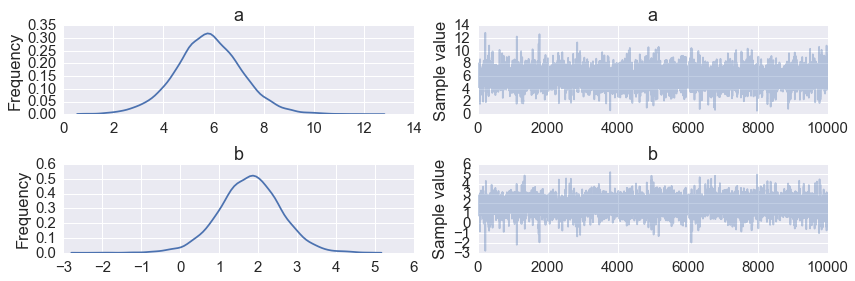

In [25]:
t = trace[niter//2:]
pm.traceplot(trace, varnames=['a', 'b'])
pass

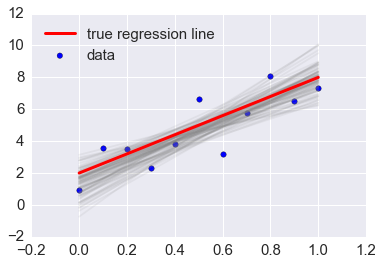

In [26]:
plt.scatter(x, y, s=30, label='data')
for a_, b_ in zip(t['a'][-100:], t['b'][-100:]):
    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)
plt.plot(x, _a*x + _b, label='true regression line', lw=3., c='red')
plt.legend(loc='best')
pass

## Using the GLM module

In [27]:
df = DataFrame({'x': x, 'y': y})
df.head()

,x,y
0,0.0,0.914369
1,0.1,3.597345
2,0.2,3.482978
3,0.3,2.293705
4,0.4,3.821400


In [28]:
with pm.Model() as model:
    pm.glm.glm('y ~ x', df)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start) 
    trace = pm.sample(2000, start=start, step=step)

Applied log-transform to sd and added transformed sd_log to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 2.7 sec

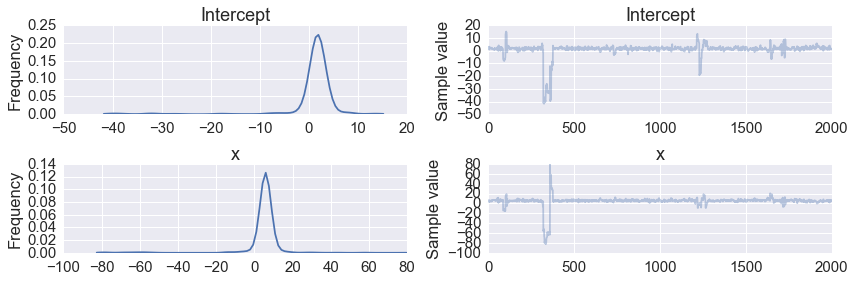

In [29]:
pm.traceplot(trace, varnames=['Intercept', 'x'])
pass

## Robust linear regression

In [30]:
# observed data
np.random.seed(123)
n = 11
_a = 6
_b = 2
x = np.linspace(0, 1, n)
y = _a*x + _b + np.random.randn(n)
y[5] *=10
df = DataFrame({'x': x, 'y': y})
df.head()

,x,y
0,0.0,0.914369
1,0.1,3.597345
2,0.2,3.482978
3,0.3,2.293705
4,0.4,3.821400


#### Scale the data

In [31]:
x, y = StandardScaler().fit_transform(df[['x', 'y']]).T

#### Effect of outlier

In [32]:
niter = 10000
with pm.Model() as linreg:
    a = pm.Normal('a', mu=0, sd=100)
    b = pm.Normal('b', mu=0, sd=100)
    sigma = pm.HalfNormal('sigma', sd=1)
    
    y_est = a*x + b     
    y_obs = pm.Normal('y_obs', mu=y_est, sd=sigma, observed=y)

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start) 
    trace = pm.sample(niter, step, start, random_seed=123)

Applied log-transform to sigma and added transformed sigma_log to model.
 [-----------------100%-----------------] 10000 of 10000 complete in 7.6 sec

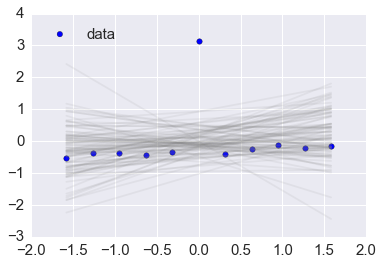

In [33]:
t = trace[niter//2:]
plt.scatter(x, y, s=30, label='data')
for a_, b_ in zip(t['a'][-100:], t['b'][-100:]):
    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)
plt.legend(loc='upper left')
pass

#### Use a T-distribution for the errors for a more robust fit

In [34]:
niter = 10000
with pm.Model() as robust_linreg:
    beta = pm.Normal('beta', 0, 10, shape=2)
    nu = pm.Exponential('nu', 1/len(x))
    sigma = pm.HalfCauchy('sigma', beta=1)

    y_est = beta[0] + beta[1]*x
    y_obs = pm.StudentT('y_obs', mu=y_est, sd=sigma, nu=nu, observed=y)

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start) 
    trace = pm.sample(niter, step, start, random_seed=123)

Applied log-transform to nu and added transformed nu_log to model.
Applied log-transform to sigma and added transformed sigma_log to model.
 [-----------------100%-----------------] 10000 of 10000 complete in 14.2 sec

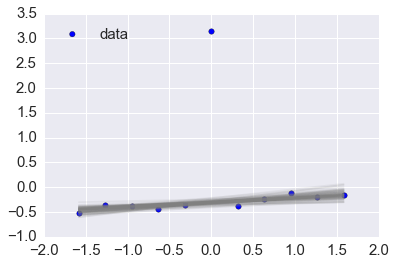

In [35]:
t = trace[niter//2:]
plt.scatter(x, y, s=30, label='data')
for a_, b_ in zip(t['beta'][-100:, 1], t['beta'][-100:, 0]):
    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)
plt.legend(loc='upper left')
pass

## Logistic regression

We will look at the effect of strongly correlated variabels using a data set from Kruschke's book.

In [36]:
df = pd.read_csv('HtWt.csv')
df.head()

,male,height,weight
0,0,63.2,168.7
1,0,68.7,169.8
2,0,64.8,176.6
3,0,67.9,246.8
4,1,68.9,151.6


In [37]:
niter = 1000
with pm.Model() as model:
    pm.glm.glm('male ~ height + weight', df, family=pm.glm.families.Binomial()) 
    start = pm.find_MAP()
    step = pm.Slice()
    trace = pm.sample(niter, start=start, step=step, njobs=4, random_seed=123)

Applied logodds-transform to p and added transformed p_logodds to model.
 [-----------------100%-----------------] 1000 of 1000 complete in 20.8 sec

#### Note poor convergence due to correlation between height and weight

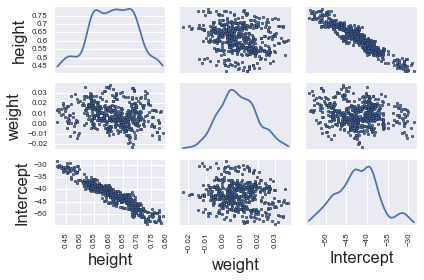

In [38]:
df_trace = pm.trace_to_dataframe(trace[niter//2:])
pd.scatter_matrix(df_trace.ix[-niter//2:, ['height', 'weight', 'Intercept']], diagonal='kde')
plt.tight_layout()
pass

#### Hamiltonian Monte Carlo is faster and converges better

In [39]:
niter = 1000
with pm.Model() as model:
    pm.glm.glm('male ~ height + weight', df, family=pm.glm.families.Binomial()) 
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(niter, start=start, step=step, njobs=4, random_seed=123)

Applied logodds-transform to p and added transformed p_logodds to model.
 [-----------------100%-----------------] 1000 of 1000 complete in 12.6 sec

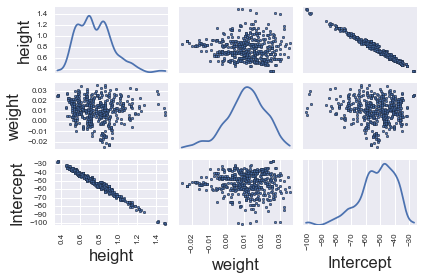

In [40]:
df_trace = pm.trace_to_dataframe(trace[niter//2:])
pd.scatter_matrix(df_trace.ix[-niter//2:, ['height', 'weight', 'Intercept']], diagonal='kde')
plt.tight_layout()
pass

## Logistic regression for classification

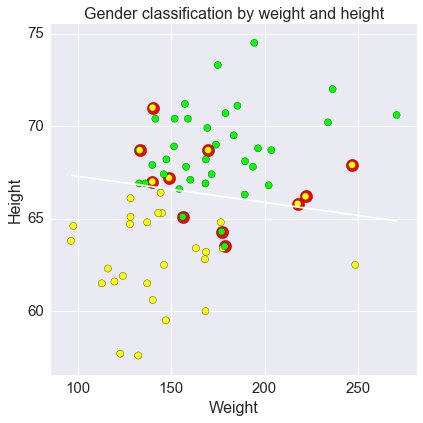

In [41]:
height, weight, intercept = df_trace[['height', 'weight', 'Intercept']].mean(0)

def predict(w, h, intercept=intercept, height=height, weight=weight):
    """Predict gender given weight (w) and height (h) values."""
    v = intercept + height*h + weight*w
    return np.exp(v)/(1+np.exp(v))

# calculate predictions on grid
xs = np.linspace(df.weight.min(), df.weight.max(), 100)
ys = np.linspace(df.height.min(), df.height.max(), 100)
X, Y = np.meshgrid(xs, ys)
Z = predict(X, Y)

plt.figure(figsize=(6,6))
# plot 0.5 contour line - classify as male if above this line
plt.contour(X, Y, Z, levels=[0.5])

# classify all subjects
colors = ['lime' if i else 'yellow' for i in df.male]
ps = predict(df.weight, df.height)
errs = ((ps < 0.5) & df.male) |((ps >= 0.5) & (1-df.male))
plt.scatter(df.weight[errs], df.height[errs], facecolors='red', s=150)
plt.scatter(df.weight, df.height, facecolors=colors, edgecolors='k', s=50, alpha=1);
plt.xlabel('Weight', fontsize=16)
plt.ylabel('Height', fontsize=16)
plt.title('Gender classification by weight and height', fontsize=16)
plt.tight_layout();

## Estimating parameters of a logistic model

Gelman's book has an example where the dose of a drug may be affected to the number of rat deaths in an experiment.

| Dose (log g/ml) | # Rats | # Deaths |
|-----------------|--------|----------|
| -0.896          | 5      | 0        |
| -0.296          | 5      | 1        |
| -0.053          | 5      | 3        |
| 0.727           | 5      | 5        |

We will model the number of deaths as a random sample from a binomial distribution, where $n$ is the number of rats and $p$ the probability of a rat dying. We are given $n = 5$, but we believe that $p$ may be related to the drug dose $x$. As $x$ increases the number of rats dying seems to increase, and since $p$ is a probability, we use the following model:

$$
y \sim \text{Bin}(n, p) \\
\text{logit}(p) = \alpha + \beta x \\
\alpha \sim \mathcal{N}(0, 5) \\
\beta \sim \mathcal{N}(0, 10)
$$

where we set vague priors for $\alpha$ and $\beta$, the parameters for the logistic model.

#### Observed data

In [42]:
n = 5 * np.ones(4)
x = np.array([-0.896, -0.296, -0.053, 0.727])
y = np.array([0, 1, 3, 5])

In [43]:
def invlogit(x):
    return pm.exp(x) / (1 + pm.exp(x))

with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=5)
    beta = pm.Flat('beta')
    
    p = invlogit(alpha + beta*x)
    y_obs = pm.Binomial('y_obs', n=n, p=p, observed=y)
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(niter, step, start, random_seed=123)

 [-----------------100%-----------------] 1000 of 1000 complete in 1.1 sec

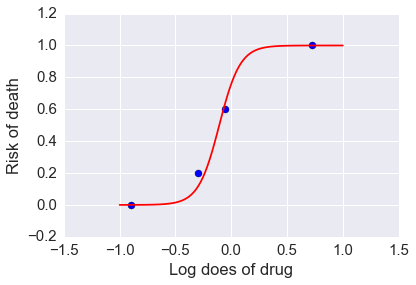

In [44]:
f = lambda a, b, xp: np.exp(a + b*xp)/(1 + np.exp(a + b*xp))

xp = np.linspace(-1, 1, 100)
a = trace.get_values('alpha').mean()
b = trace.get_values('beta').mean()
plt.plot(xp, f(a, b, xp), c='red')
plt.scatter(x, y/5, s=50);
plt.xlabel('Log does of drug')
plt.ylabel('Risk of death')
pass

## Hierarchical model

This uses the Gelman radon data set and is based off this [IPython notebook](http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/). Radon levels were measured in houses from all counties in several states. Here we want to know if the presence of a basement affects the level of radon, and if this is affected by which county the house is located in. 

The data set provided is just for the state of Minnesota, which has 85 counties with 2 to 116 measurements per county. We only need 3 columns for this example `county`, `log_radon`, `floor`, where `floor=0` indicates that there is a basement.

We will perform simple linear regression on log_radon as a function of county and floor.

In [45]:
radon = pd.read_csv('radon.csv')[['county', 'floor', 'log_radon']]
radon.head()

,county,floor,log_radon
0,AITKIN,1,0.832909
1,AITKIN,0,0.832909
2,AITKIN,0,1.098612
3,AITKIN,0,0.095310
4,ANOKA,0,1.163151


#### Hierarchical model

With a hierarchical model, there is an $a_c$ and a $b_c$ for each county $c$ just as in the individual county model, but they are no longer independent but assumed to come from a common group distribution

$$
a_c \sim \mathcal{N}(\mu_a, \sigma_a^2) \\
b_c \sim \mathcal{N}(\mu_b, \sigma_b^2)
$$

we further assume that the hyperparameters come from the following distributions

$$
\mu_a \sim \mathcal{N}(0, 10^2) \\
\sigma_a \sim \text{|Cauchy(1)|} \\ 
\mu_b \sim \mathcal{N}(0, 10^2) \\
\sigma_b \sim \text{|Cauchy(1)|} \\ 
$$

In [46]:
county = pd.Categorical(radon['county']).codes

niter = 1000
with pm.Model() as hm:
    # County hyperpriors
    mu_a = pm.Normal('mu_a', mu=0, sd=10)
    sigma_a = pm.HalfCauchy('sigma_a', beta=1)
    mu_b = pm.Normal('mu_b', mu=0, sd=10)
    sigma_b = pm.HalfCauchy('sigma_b', beta=1)
    
    # County slopes and intercepts
    a = pm.Normal('slope', mu=mu_a, sd=sigma_a, shape=len(set(county)))
    b = pm.Normal('intercept', mu=mu_b, sd=sigma_b, shape=len(set(county)))
    
    # Houseehold errors
    sigma = pm.Gamma("sigma", alpha=10, beta=1)
    
    # Model prediction of radon level
    mu = a[county] + b[county] * radon.floor.values
    
    # Data likelihood
    y = pm.Normal('y', mu=mu, sd=sigma, observed=radon.log_radon)

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    hm_trace = pm.sample(niter, step, start=start)

Applied log-transform to sigma_a and added transformed sigma_a_log to model.
Applied log-transform to sigma_b and added transformed sigma_b_log to model.
Applied log-transform to sigma and added transformed sigma_log to model.
 [-----------------100%-----------------] 1001 of 1000 complete in 6271.3 sec

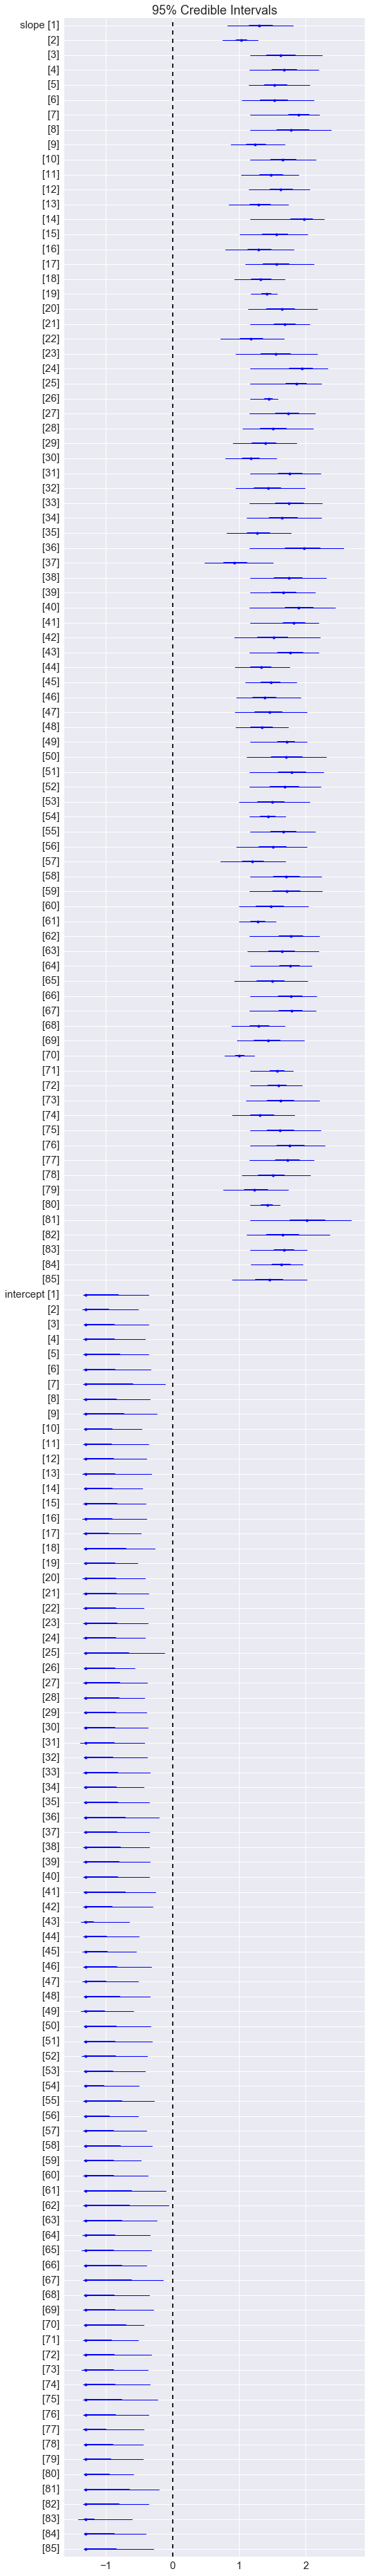

In [47]:
plt.figure(figsize=(8, 60))
pm.forestplot(hm_trace, varnames=['slope', 'intercept'])
pass

## Bandits

In [48]:
%load_ext version_information
%version_information numpy, scipy, matplotlib, seaborn, pymc3

Software versions
Python 3.5.1 64bit [GCC 4.2.1 (Apple Inc. build 5577)]
IPython 4.0.1
OS Darwin 15.3.0 x86_64 i386 64bit
numpy 1.10.4
scipy 0.17.0
matplotlib 1.5.1
seaborn 0.7.0
pymc3 3.0
Mon Feb 29 21:45:46 2016 EST